In [51]:
# 导入ricequant
import os
os.environ["RQDATAC2_CONF"] = "rqdata://license:c9qmzpaiaJ2ZISkX0wjCCypHhcODsOPMeIMPBp-xZcwujI3nkirkvIzie9RGooYOBvg02G0_6RY3-0fGpfBMVVHh2Dk608UfSx71AptxtMHmXjqwbiL0LS03ZEp9Q4AzDfB-cY0aWOhsLrPeJqkVdeGHyMIwMXa6xISmt6tUPsg=VI1TWeRAs6fo-Tz3A8YTOE1gEzOeQkxJSkHWyawl5dMI86NdDkUu617N0fDEOeoFV-6-lzvQkhE5qrf5N8IQpt9vcMTnoSwnnes5aYG6am74w-pporQXanNMH7d3SuBAlGHS_ixnVWZRyVm1YjrAAveqn0fKgJoUVl2x3ga0EK4=@rqdatad-pro.ricequant.com:16011"
# print(os.environ.get("RQDATAC2_CONF"))
import rqdatac as rq
rq.init()

/opt/anaconda3/envs/finmod/lib/python3.10/site-packages/rqdatac/client.py:224: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)


In [52]:
# 导入其他包
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [53]:
# 获取持仓数据
# akshare上的数据只精确到“万”，四舍五入带来的问题严重，故直接从基金2021年年报获取持仓数据

# 股票持仓数据
current_folder = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_folder, ".."))
target_file_path = os.path.join(parent_folder, "data", "中欧时代先锋股票型基金2021年持仓明细.csv")
stock_hold = pd.read_csv(target_file_path, dtype={"股票代码": str})

# 清洗股票持仓数据
stock_hold["股票代码"] = stock_hold["股票代码"].str.zfill(6) # 补全股票代码前导0
stock_hold.set_index("股票代码", inplace=True) # 设置index

# 2021年底仅持0.06%的21国债01，对组合收益影响微乎其微，故直接忽略

In [54]:
stock_hold.head(10)

,序号,股票名称,数量（股）,公允价值（元）,占基金资产净值比例（%）
股票代码,,,,,
002475,1,立讯精密,38631788,1.900684e+09,8.52
002415,2,海康威视,22928442,1.199616e+09,5.37
300454,3,深信服,6258946,1.195459e+09,5.36
300750,4,宁德时代,1998366,1.175039e+09,5.26
300413,5,芒果超媒,17101103,9.571318e+08,4.29
603799,6,华友钴业,7637836,8.425297e+08,3.77
600660,7,福耀玻璃,14535546,6.852056e+08,3.07
002466,8,天齐锂业,5800858,6.206918e+08,2.78
002460,9,赣锋锂业,3738223,5.340052e+08,2.39


In [55]:
# 获取stock_hold的市场数据
stock_codes = stock_hold.index.tolist()

# 给股票代码加上市场归属
def add_market_suffix(code):
    """根据股票代码判断市场，添加对应后缀"""
    if code.startswith(("00", "30")):  # 深市（00开头/30开头）
        return f"{code}.XSHE"
    elif code.startswith(("60", "68")):  # 沪市（60开头/68开头）
        return f"{code}.XSHG"
    else:
        print(f"⚠️  无法识别股票代码 {code} 的市场，跳过该股票")
        return None
    
# 批量添加后缀，过滤无效代码
stock_codes_with_suffix = []
for code in stock_hold.index.tolist():
    suffix_code = add_market_suffix(code)
    if suffix_code:  # 只保留有效代码
        stock_codes_with_suffix.append(suffix_code)

start_date = 20211231
end_date = 20221231
fields = "close"
frequency = "1d"
adjust_type = "pre"

all_stock = rq.get_price(stock_codes_with_suffix, 
                              start_date=start_date, 
                              end_date=end_date, 
                              fields=fields,
                              frequency=frequency, 
                              adjust_type=adjust_type
                              )

# 清洗市场数据
all_stock.reset_index(inplace=True)

# 去掉市场后缀，与stock_hold对应
all_stock["order_book_id"] = (
    all_stock["order_book_id"]
    .astype(str)
    .str.replace(r"\..*", "", regex=True)
)

In [56]:
# 构建价格矩阵、持仓矩阵

# 价格矩阵（日期x股票）
price_matrix = all_stock.pivot_table(
    index = "date",
    columns = "order_book_id",
    values = "close"
)
price_matrix = price_matrix.sort_index()
price_matrix.index = pd.to_datetime(price_matrix.index)

# 处理价格矩阵缺失值
# 一些股票2022开年后才上市，但2021年报中已有持仓（预申购）。使用发行价填充上市前价格
unlisted_stock_info = {
    "001234": {"issue_price": 16.53, "listing_date": "2022-01-11"},
    "301136": {"issue_price": 10.52, "listing_date": "2022-01-11"},
    "688176": {"issue_price": 22.98, "listing_date": "2022-01-07"},
    "688262": {"issue_price": 41.98, "listing_date": "2022-01-06"}
}

for stock_code, info in unlisted_stock_info.items():
    if stock_code in price_matrix.columns:
        listing_date = pd.to_datetime(info["listing_date"])
        issue_price = info["issue_price"]
        
        # 找到上市日期之前的所有日期索引
        # 逻辑：时间 < 上市日期 AND 值为空(NaN)
        mask_date = price_matrix.index < listing_date
        mask_nan = price_matrix[stock_code].isna()
        
        final_mask = mask_date & mask_nan # 取交集：既要是上市前，又要确实是空值的
        
        # 执行填充
        price_matrix.loc[final_mask, stock_code] = issue_price
    else:
        print(f"⚠️ 股票 {stock_code} 不在价格矩阵中，跳过")

# 检查并处理 stock_hold 中的重复索引
# 原始数据里，存在同一只股票被分成了多行记录（例如流通股和受限股分开列示），现在把它们合并
if stock_hold.index.duplicated().any():
    print(f"⚠️ 检测到 {stock_hold.index.duplicated().sum()} 个重复的股票代码，已合并")
    # 对重复的股票代码进行聚合：数值列求和，非数值列取第一个
    stock_hold = stock_hold.groupby(level=0).agg({
        "股票名称": "first",
        "数量（股）": "sum",
        "公允价值（元）": "sum",
        # 其他需要的列也可以在这里加
    })

# 持仓矩阵（股票x持仓股数）

# 在调用价格的时候使用了前复权（将历史价格向下调整，以剔除分红、配股、拆细等对股价走势的“断层”影响，从而保证收益率曲线的连续性）
# 但是，2021年年报中的“持仓市值”是基于2021年12月31日当天的真实收盘价计算的
# 这会导致初始持仓金额对不上

# hold_matrix = stock_hold.pivot_table(
#     index = "股票代码",
#     values = "数量（股）"
# )

price_20211231 = price_matrix.loc['2021-12-31']
real_market_value = stock_hold['公允价值（元）']
simulated_shares = real_market_value / price_20211231

hold_matrix = simulated_shares.reindex(price_matrix.columns).fillna(0)

⚠️ 检测到 3 个重复的股票代码，已合并


In [57]:
# 计算日度回报
simulated_daily_return = price_matrix.dot(hold_matrix).to_frame(name="Stock_Asset") # 矩阵向量乘法

# 持仓Net Value除了股票外，还有债券（占总市值0.06%的国债）、买入返售金融资产、银行存款和结算备付金合计、其他各项资产
# 提取财报中的非股票资产金额 (单位：元)
bond_val = 12955590.60 # 债券 (固定收益投资)
repo_val = 53600000.00 # 买入返售金融资产
cash_val = 2291462062.61 # 银行存款和结算备付金
other_val = 88935241.68 # 其他各项资产
liabilities = 564231252.68 # 总负债
non_equity_sum = bond_val + repo_val + cash_val + other_val - liabilities # 非权益类资产总和

simulated_daily_return["Simulated Net Value"] = simulated_daily_return["Stock_Asset"] + non_equity_sum # 总净值 = 动态的股票市值 + 静态的非股票资产

simulated_daily_return["Simulated Daily Return"] = simulated_daily_return["Simulated Net Value"].pct_change() * 100 # 计算日度收益率

simulated_daily_return.head(5)

,Stock_Asset,Simulated Net Value,Simulated Daily Return
date,,,
2021-12-31,2.043831e+10,2.232103e+10,NaN
2022-01-04,2.017293e+10,2.205565e+10,-1.188923
2022-01-05,1.946432e+10,2.134704e+10,-3.212812
2022-01-06,1.935647e+10,2.123919e+10,-0.505238
2022-01-07,1.904142e+10,2.092414e+10,-1.483328


In [58]:
# 获取2022年基金实际行情数据
order_book_ids = ["001938", "004241"] # 001938：中欧时代先锋股票A；004241：中欧时代先锋股票C
start_date = 20211231
end_date = 20221231
fields = ["unit_net_value", "change_rate"]

daily_return_AC = rq.fund.get_nav(
    order_book_ids=order_book_ids,
    start_date=start_date,
    end_date=end_date,
    fields=fields,
    expect_df=True
)

daily_return_AC = daily_return_AC.reset_index()

daily_return_AC.head(5)

,order_book_id,datetime,unit_net_value,change_rate
0,001938,2021-12-31,1.8666,0.010940
1,001938,2022-01-04,1.8441,-0.012054
2,001938,2022-01-05,1.7838,-0.032699
3,001938,2022-01-06,1.7773,-0.003644
4,001938,2022-01-07,1.7517,-0.014404


In [59]:
# 根据A、C的不同发行份额计算整个“中欧时代先锋股票”的daily return
navs_pivot = daily_return_AC.pivot(
    index = "datetime",
    columns = "order_book_id",
    values = "unit_net_value"
)

share_001938 = 9685321514.86
share_004241 = 2338391846.83

# 计算daily return
asset_A = navs_pivot['001938'] * share_001938
asset_C = navs_pivot['004241'] * share_004241

total_asset = asset_A + asset_C

combined_daily_return = total_asset.pct_change()

real_daily_return = pd.DataFrame({
    "Real Net Value": total_asset,
    "Real Daily Return": combined_daily_return
}).reset_index()

real_daily_return.rename(columns={"datetime": "date"}, inplace=True) # 更改列名，与simulated_daily_return统一

real_daily_return.set_index("date", inplace=True)

real_daily_return.head(5)

,Real Net Value,Real Daily Return
date,,
2021-12-31,2.232117e+10,NaN
2022-01-04,2.205157e+10,-0.012078
2022-01-05,2.133051e+10,-0.032699
2022-01-06,2.125259e+10,-0.003653
2022-01-07,2.094666e+10,-0.014395


In [60]:
# 验证：20211231的净值能跟财报对上
target_date = pd.to_datetime("20211231")

nav_20211231 = real_daily_return.loc[target_date, "Real Net Value"]
real_nav_20211231 = 22321531418.64

difference = nav_20211231 - real_nav_20211231

difference_in_percentage = difference / real_nav_20211231 * 100

print(f"20211231总净值：{nav_20211231:.2f}元")
print(f"2021财报披露净值：22321531418.64 元")
print(f"差异约{difference/10000:.2f}万元，与223亿元的总资产相比仅为{difference_in_percentage:.4f}%，可以忽略")

20211231总净值：22321165467.34元
2021财报披露净值：22321531418.64 元
差异约-36.60万元，与223亿元的总资产相比仅为-0.0016%，可以忽略


===== 业绩表现对比 =====
             累计收益     年化收益    年化波动     最大回撤     夏普比率
模拟组合(静态)  -26.98%  -27.64%  24.21%  -34.18%  -1.2244
真实基金(动态)  -25.75%  -26.38%  25.16%  -35.04%  -1.1278

基金经理日度跑赢模拟组合的概率 (真实跑赢模拟的天数占比): 51.03%


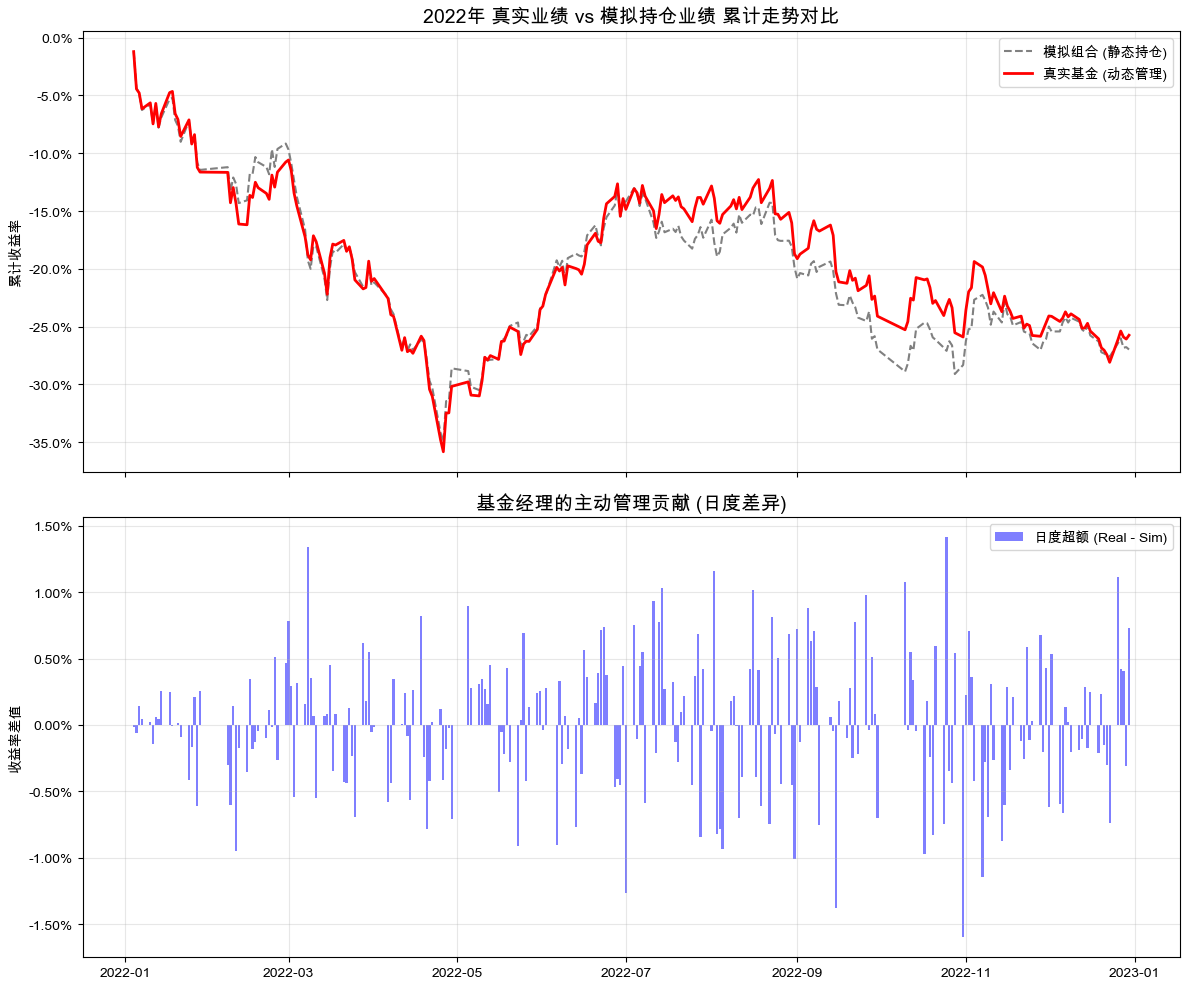

In [61]:
# 结果分析（by Gemini）

# ==========================================
# 1. 数据准备与对齐
# ==========================================
# 确保索引都是 datetime 类型
simulated_daily_return.index = pd.to_datetime(simulated_daily_return.index)
real_daily_return.index = pd.to_datetime(real_daily_return.index)

# 合并数据 (Inner Join 确保日期一致)
# 注意：您的代码中 simulated 是百分数(*100)，real 是小数(pct_change)，这里统一转换为“小数”
comparison_df = pd.merge(
    simulated_daily_return[["Simulated Daily Return"]],
    real_daily_return[["Real Daily Return"]],
    left_index=True,
    right_index=True
)

# 统一单位：将模拟组合的百分数转回小数
comparison_df["Ret_Sim"] = comparison_df["Simulated Daily Return"] / 100
comparison_df["Ret_Real"] = comparison_df["Real Daily Return"]

# 计算“主动管理带来的超额收益” (Real - Sim)
comparison_df["Active_Return"] = comparison_df["Ret_Real"] - comparison_df["Ret_Sim"]

# ==========================================
# 2. 计算核心指标
# ==========================================
def calculate_metrics(series):
    # 累计收益
    cum_ret = (1 + series).cumprod().iloc[-1] - 1
    # 年化收益 (假设250个交易日)
    ann_ret = (1 + series).prod() ** (250 / len(series)) - 1
    # 年化波动率
    ann_vol = series.std() * np.sqrt(250)
    # 最大回撤
    cum_series = (1 + series).cumprod()
    max_drawdown = (cum_series / cum_series.cummax() - 1).min()
    # 夏普比率 (假设无风险利率为0，简化计算)
    sharpe = (ann_ret - 0.02) / ann_vol # 假设年化无风险利率2%
    
    return {
        "累计收益": f"{cum_ret:.2%}",
        "年化收益": f"{ann_ret:.2%}",
        "年化波动": f"{ann_vol:.2%}",
        "最大回撤": f"{max_drawdown:.2%}",
        "夏普比率": f"{sharpe:.4f}"
    }

metrics_sim = calculate_metrics(comparison_df["Ret_Sim"])
metrics_real = calculate_metrics(comparison_df["Ret_Real"])

# 展示指标对比表
metrics_df = pd.DataFrame([metrics_sim, metrics_real], index=["模拟组合(静态)", "真实基金(动态)"])
print("===== 业绩表现对比 =====")
print(metrics_df)

# 计算胜率 (真实跑赢模拟的天数占比)
win_rate = (comparison_df["Active_Return"] > 0).mean()
print(f"\n基金经理日度跑赢模拟组合的概率 (真实跑赢模拟的天数占比): {win_rate:.2%}")

# ==========================================
# 3. 可视化绘图
# ==========================================
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 防止中文乱码 (MacOS用Arial Unicode MS, Windows用SimHei)
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 图1：累计收益率曲线
cum_returns = (1 + comparison_df[["Ret_Sim", "Ret_Real"]]).cumprod() - 1
ax[0].plot(cum_returns.index, cum_returns["Ret_Sim"], label="模拟组合 (静态持仓)", color='gray', linestyle='--')
ax[0].plot(cum_returns.index, cum_returns["Ret_Real"], label="真实基金 (动态管理)", color='red', linewidth=2)
ax[0].set_title("2022年 真实业绩 vs 模拟持仓业绩 累计走势对比", fontsize=14)
ax[0].set_ylabel("累计收益率")
ax[0].legend()
ax[0].grid(True, alpha=0.3)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# 图2：主动管理差异 (Real - Sim)
# 正值代表当天基金经理通过调仓跑赢了静态持仓
ax[1].bar(comparison_df.index, comparison_df["Active_Return"], color='blue', alpha=0.5, label="日度超额 (Real - Sim)")
ax[1].set_title("基金经理的主动管理贡献 (日度差异)", fontsize=14)
ax[1].set_ylabel("收益率差值")
ax[1].legend()
ax[1].grid(True, alpha=0.3)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

In [62]:
# Carhart四因子超额回报

# 读取数据文件
current_folder = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_folder, ".."))
target_file_path = os.path.join(parent_folder, "data", "Carhart-四因子模型（经典算法）日收益率（截至到20250630）.csv")
factor_car = pd.read_csv(target_file_path)

# 处理数据
factor_car['date'] = pd.to_datetime(factor_car['date'])
factor_car.set_index('date', inplace=True)
factor_car = factor_car[(factor_car.index >= pd.to_datetime("20211231")) & 
                        (factor_car.index <= pd.to_datetime("20221231"))].copy() # 保留20211231-20221231之间的数据

# 模拟数据回归
# 数据处理
car_data_sim = pd.merge(simulated_daily_return[['Simulated Daily Return']], factor_car, left_index=True, right_index=True, how='inner')
car_data_sim['Ri_Rf'] = car_data_sim['Simulated Daily Return'] / 100 - car_data_sim['RF'] # 转换为小数形式的超额收益
car_data_sim['Market'] = car_data_sim['MKT'] - car_data_sim['RF']
car_data_sim = car_data_sim.dropna().copy() # 删除缺失值

# 回归模型设置
formula = 'Ri_Rf ~ Market + SMB + HML + UMD'
model = smf.ols(formula=formula, data=car_data_sim).fit(cov_type='HC1')

# 整理结果
alpha_daily_sim = model.params["Intercept"]
alpha_annualized_sim = alpha_daily_sim * 250
p_value = model.pvalues['Intercept']
print(model.summary())
print(f"模拟年化超额收益为{alpha_annualized_sim:.2%}")

                            OLS Regression Results                            
Dep. Variable:                  Ri_Rf   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     511.1
Date:                Fri, 21 Nov 2025   Prob (F-statistic):          3.12e-115
Time:                        16:20:34   Log-Likelihood:                 965.59
No. Observations:                 242   AIC:                            -1921.
Df Residuals:                     237   BIC:                            -1904.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.583e-05      0.000     -0.329      0.7

In [63]:
# 对真实基金做同样的回归，以便比较
# 数据处理
car_data_real = pd.merge(real_daily_return[['Real Daily Return']], factor_car, left_index=True, right_index=True, how='inner')
car_data_real['Ri_Rf'] = car_data_real['Real Daily Return'] - car_data_real['RF']
car_data_real['Market'] = car_data_real['MKT'] - car_data_real['RF']
car_data_real = car_data_real.dropna().copy() # 删除缺失值

# 回归模型设置
formula = 'Ri_Rf ~ Market + SMB + HML + UMD'
model = smf.ols(formula=formula, data=car_data_real).fit(cov_type='HC1')

# 整理结果
alpha_daily_real = model.params["Intercept"]
alpha_annualized_real = alpha_daily_real * 250
p_value = model.pvalues['Intercept']
print(model.summary())
print(f"真实年化超额收益为{alpha_annualized_real:.2%}")

                            OLS Regression Results                            
Dep. Variable:                  Ri_Rf   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     494.0
Date:                Fri, 21 Nov 2025   Prob (F-statistic):          1.14e-113
Time:                        16:20:34   Log-Likelihood:                 923.33
No. Observations:                 242   AIC:                            -1837.
Df Residuals:                     237   BIC:                            -1819.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.445e-05      0.000      0.133      0.8

自变量之间的多重共线性已经在01中检验过，不存在多重共线性。

# Just Play: 对回报率做PCA
试图找统计因子（PCA）与经济因子（Carhart四因子）的相关性——套利定价理论（APT）与多因子模型（如Fama-French三因子模型）的结合。

传统的因子分析（如CAPM、Carhart模型）本质上是一种自上而下的假设驱动（Hypothesis-driven）验证，即预设特定因子有效，进而检验其解释力。然而，这种方法面临着“模型设定偏差”的局限性：**驱动基金收益的真实核心变量可能并未被包含在预设的经典模型中，或者表现为多个因子的复杂非线性组合。**

因此，本研究引入主成分分析（PCA）作为补充。PCA能够从收益率数据的底层结构出发，自下而上、Data-driven地提取出对方差解释度最高的潜在统计主成分。通过进一步分析这些“统计因子”与广泛的“经济因子”（包括传统风格因子及行为金融因子）之间的协方差及相关性，我们不仅能够客观评估现有模型的有效性边界，更能精准**识别出那些被传统模型遗漏、但对基金业绩具有实质驱动力的深层经济逻辑**。

In [64]:
# 1. 准备数据：使用 price_matrix 计算日收益率
# price_matrix 是 (日期 x 股票) 的收盘价矩阵
returns_matrix = price_matrix.pct_change().dropna()

# 2. 标准化 (Standardization) - 非常关键！
# 因为不同股票的波动率不同，不标准化的话，高波动的股票会主导 PCA 结果
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns_matrix)

# 3. 运行 PCA
# n_components=10 表示我们只想看前10个最重要的因子
pca = PCA(n_components=10)
pca.fit(scaled_returns)

# --- 结果获取 ---

# A. 解释方差 (Explained Variance)
# 这告诉我们每个主成分解释了市场多少波动
print("解释方差比例:", pca.explained_variance_ratio_)
print("前4个因子累计解释:", np.sum(pca.explained_variance_ratio_[:4]))

# B. 因子载荷 (Factor Loadings / Eigenvectors)
# 这告诉我们每个股票受该因子的影响有多大 (N_stocks x N_components)
loadings = pd.DataFrame(pca.components_.T, index=returns_matrix.columns, columns=[f'PC{i+1}' for i in range(10)])

# C. 因子收益序列 (Factor Returns / PC Scores)
# 这是提炼出来的“合成因子”每天的涨跌幅 (T_days x N_components)
factor_returns = pd.DataFrame(pca.transform(scaled_returns), index=returns_matrix.index, columns=[f'PC{i+1}' for i in range(10)])

解释方差比例: [0.27858165 0.05669964 0.03840059 0.0304061  0.02173046 0.02117662
 0.01654225 0.01563497 0.01473287 0.01354238]
前4个因子累计解释: 0.404087986717043


In [65]:
factor_returns.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
date,,,,,,,,,,
2022-01-04,-3.739049,7.130647,0.015076,-1.855635,3.422191,4.196981,-3.152230,-2.121069,1.438701,-0.170495
2022-01-05,-11.833800,1.526060,0.397548,-1.340022,-3.028385,3.408035,-2.756983,-1.819301,1.630069,-0.586443
2022-01-06,3.442349,2.250593,-3.594192,-3.223847,0.622361,-2.361135,1.995072,0.028858,0.850445,-1.549397
2022-01-07,-7.581423,0.360313,2.949537,2.921332,-3.493528,2.232872,2.142374,2.577224,2.218783,0.326707
2022-01-10,4.554060,5.479361,0.301912,-1.198455,0.340786,0.375289,-0.206006,4.372647,0.859632,-0.613650


In [ ]:
# 1. 准备数据
# y: 基金模拟组合的日收益率 (注意要和 PCA 的时间索引对齐)
# 假设您之前的变量叫 simulated_daily_return (记得确保它是小数，不是百分数)
y_fund = simulated_daily_return['Simulated Daily Return'] / 100  
y_fund = y_fund.reindex(factor_returns.index).dropna() # 确保日期对齐

# X: PCA 提取出的前 5 个主成分的日收益率
# 我们只看前几个主要矛盾，太后面的通常是噪音
X_factors = factor_returns[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] 

# 2. 运行回归 (Factor Attribution)
X_with_const = sm.add_constant(X_factors)
model_pca_attribution = sm.OLS(y_fund, X_with_const).fit(cov_type="HC1")

print(model_pca_attribution.summary())

# 3. 核心解读
print("\n[深度归因结论]")
print(f"1. 解释力度 (R-squared): {model_pca_attribution.rsquared:.2%}")
print("   含义: 基金 %s 的波动可以完全由这前5个统计因子解释。" % (f"{model_pca_attribution.rsquared:.2%}"))

print(f"\n2. 市场因子暴露 (PC1 Beta): {model_pca_attribution.params['PC1']:.4f}")
if model_pca_attribution.params['PC1'] > 0:
    print("   含义: 基金与市场主趋势(PC1)正相关，PC1涨基金就涨。")

print("\n3. 风格/行业因子暴露 (PC2 Beta):")
print(f"   系数: {model_pca_attribution.params['PC2']:.4f}")
print("   (请结合之前的 Loadings 分析 PC2 代表什么风格)")

                              OLS Regression Results                              
Dep. Variable:     Simulated Daily Return   R-squared:                       0.966
Model:                                OLS   Adj. R-squared:                  0.966
Method:                     Least Squares   F-statistic:                     1370.
Date:                    Fri, 21 Nov 2025   Prob (F-statistic):          4.19e-172
Time:                            16:21:03   Log-Likelihood:                 1078.9
No. Observations:                     242   AIC:                            -2146.
Df Residuals:                         236   BIC:                            -2125.
Df Model:                               5                                         
Covariance Type:                      HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       

PC1 中载荷为正的股票比例: 100.00%
结论: PC1 具有显著的'同涨同跌'特征，大概率是市场因子。

[PCA因子 与 Carhart因子 相关性矩阵]
          MKT       SMB       HML       UMD
PC1  0.856867  0.534427 -0.668808  0.165292
PC2  0.125700  0.326261  0.408557 -0.323501
PC3  0.284580 -0.529794  0.019841 -0.134929
PC4 -0.201799  0.220551 -0.254440 -0.162741


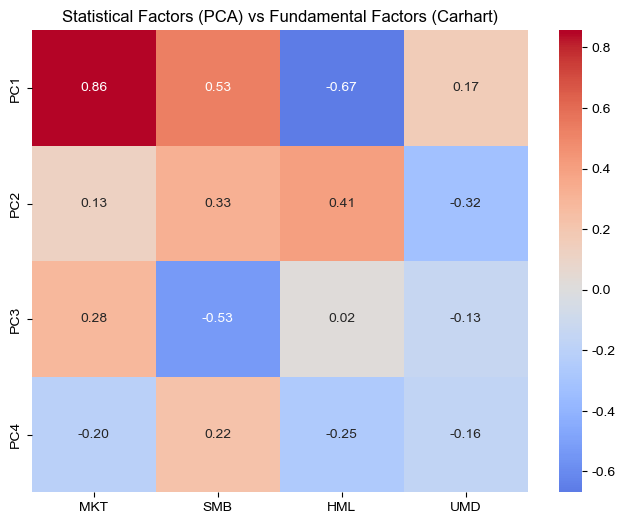

In [68]:
# PCA因子与Carhart四因子的相关性

import seaborn as sns

# ==========================================
# 1. 验证 PC1 是否为市场因子
# ==========================================
# 获取 PC1 的因子载荷 (Loadings)
# 假设 pca 是您训练好的模型，returns_df 是股票收益率数据
pc1_loadings = pca.components_[0] 

# 检查正负号一致性
positive_ratio = np.sum(pc1_loadings > 0) / len(pc1_loadings)
print(f"PC1 中载荷为正的股票比例: {positive_ratio:.2%}")
if positive_ratio > 0.8 or positive_ratio < 0.2:
    print("结论: PC1 具有显著的'同涨同跌'特征，大概率是市场因子。")

# ==========================================
# 2. 统计因子(PCA) vs 经济因子(Carhart) 相关性分析
# ==========================================
# 准备数据：截取相同时间段
common_index = factor_returns.index.intersection(factor_car.index)
pca_factors = factor_returns.loc[common_index, ['PC1', 'PC2', 'PC3', 'PC4']] # 只取显著的前4个
carhart_factors = factor_car.loc[common_index, ['MKT', 'SMB', 'HML', 'UMD']]

# 计算相关系数矩阵
correlation_matrix = pd.concat([pca_factors, carhart_factors], axis=1).corr()

# 只看 PCA vs Carhart 的部分
# 行是 PCA 因子，列是 Carhart 因子
cross_corr = correlation_matrix.loc[['PC1', 'PC2', 'PC3', 'PC4'], ['MKT', 'SMB', 'HML', 'UMD']]

print("\n[PCA因子 与 Carhart因子 相关性矩阵]")
print(cross_corr)

# 可视化热力图
plt.figure(figsize=(8, 6))
sns.heatmap(cross_corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Statistical Factors (PCA) vs Fundamental Factors (Carhart)")
plt.show()

统计因子分析表明，该基金并非简单的‘高$\beta$’产品。虽然第一主成分（PC1）呈现出显著的‘成长型市场’特征（高MKT相关，负HML相关），但第二、三主成分揭示了基金内部存在显著的‘大盘价值’对冲机制（正HML相关，负SMB相关）。这种‘成长进攻 + 蓝筹防守’的立体持仓结构，解释了其为何能在部分市场环境下跑赢纯粹的风格指数。